[9, 15, 18, 21, 26, 27, 28]
[5, 9, 15, 18, 21, 26, 27, 28]
[5, 9, 15, 18, 21, 26, 27, 28]


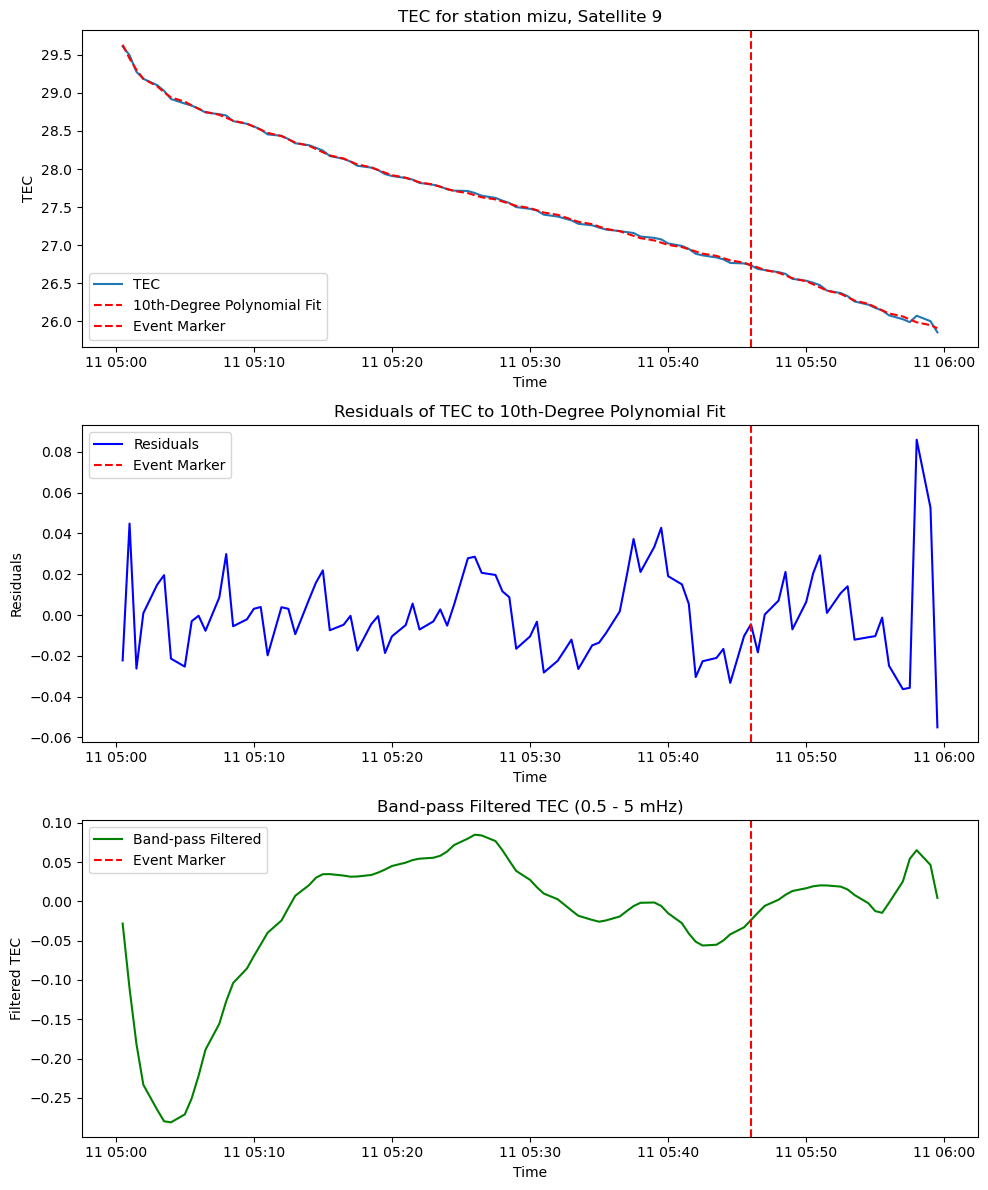

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
event_time = "2011-03-11 05:46:00"
# Load and preprocess data
df = pd.read_csv('data/data_csvs/Japan_Tsunami_11Mar2011_05_07.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
df.set_index('datetime', inplace=True)

def get_satellites_in_contact(df, station_id, event_time):
    event_time = pd.to_datetime(event_time)
    df_filtered = df[(df['gps_site'] == station_id) & (df.index == event_time)]
    satellites_in_contact = df_filtered['sat_id'].unique()
    return satellites_in_contact.tolist()
satellites = get_satellites_in_contact(df,'g103',event_time)
print(satellites)
satellites = get_satellites_in_contact(df,'mizu',event_time)
print(satellites)
satellites = get_satellites_in_contact(df,'g205',event_time)
print(satellites)
def calculate_residuals(data, order=10):
    time_numeric = np.arange(len(data))
    poly_coeffs = np.polyfit(time_numeric, data, order)
    fitted_values = np.polyval(poly_coeffs, time_numeric)
    residuals = data - fitted_values
    return residuals

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def get_residuals(df, station_id, sat_id, start_time, end_time, tec_type="los_tec"):
    df_filtered = df[(df['gps_site'] == station_id) & 
                     (df['sat_id'] == sat_id) & 
                     (df['datetime'] >= start_time) & 
                     (df['datetime'] <= end_time)]
    residuals = calculate_residuals(df_filtered[tec_type])
    return residuals

def get_band_filtered_data(df, station_id, sat_id, start_time, end_time, lowcut=0.5e-3, highcut=5e-3, tec_type="los_tec"):
    df_filtered = df[(df['gps_site'] == station_id) & 
                     (df['sat_id'] == sat_id) & 
                     (df['datetime'] >= start_time) & 
                     (df['datetime'] <= end_time)]
    sampling_interval = (df_filtered['datetime'].iloc[1] - df_filtered['datetime'].iloc[0]).total_seconds()
    fs = 1 / sampling_interval
    filtered_data = bandpass_filter(df_filtered[tec_type], lowcut, highcut, fs)
    return pd.Series(filtered_data, index=df_filtered['datetime'])

def plot_combined(df, station_id, sat_id, start_time, end_time, event_time, lowcut=0.5e-3, highcut=5e-3, tec_type="los_tec"):

    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    event_time = pd.to_datetime(event_time)
    
    df_filtered = df[(df['gps_site'] == station_id) & 
                     (df['sat_id'] == sat_id) & 
                     (df['datetime'] >= start_time) & 
                     (df['datetime'] <= end_time)].copy()
    df_filtered.set_index('datetime', inplace=True)
    
    residuals = calculate_residuals(df_filtered[tec_type])
    sampling_interval = (df_filtered.index[1] - df_filtered.index[0]).total_seconds()
    fs = 1 / sampling_interval
    filtered_data = bandpass_filter(df_filtered[tec_type], lowcut, highcut, fs)
    
    # Plot LOS TEC or TEC with Polynomial Fit
    time_numeric = np.arange(len(df_filtered[tec_type]))
    poly_coeffs = np.polyfit(time_numeric, df_filtered[tec_type], 10)
    tec_fit = np.polyval(poly_coeffs, time_numeric)
    
    plt.figure(figsize=(10, 12))
    plt.subplot(3, 1, 1)
    plt.plot(df_filtered.index, df_filtered[tec_type], label=tec_type.upper())
    plt.plot(df_filtered.index, tec_fit, color='red', linestyle='--', label="10th-Degree Polynomial Fit")
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"{tec_type.upper()} for station {station_id}, Satellite {sat_id}")
    plt.xlabel("Time")
    plt.ylabel(tec_type.upper())
    plt.legend()

    # Plot Residuals
    plt.subplot(3, 1, 2)
    plt.plot(df_filtered.index, residuals, label="Residuals", color='blue')
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"Residuals of {tec_type.upper()} to 10th-Degree Polynomial Fit")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    
    # Plot Band-pass Filtered Data
    plt.subplot(3, 1, 3)
    plt.plot(df_filtered.index, filtered_data, label="Band-pass Filtered", color='green')
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"Band-pass Filtered {tec_type.upper()} (0.5 - 5 mHz)")
    plt.xlabel("Time")
    plt.ylabel("Filtered " + tec_type.upper())
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage with option to switch between los_tec and tec
station_id = 'mizu'
sat_id = 9

start_time = '2011-03-11 05:00:00'
end_time = '2011-03-11 08:00:00'
event_time = "2011-03-11 05:46:00"

# Call the plot function with either 'los_tec' or 'tec'
df = pd.read_csv('tohoku_filtered_data.csv')
df['datetime'] = pd.to_datetime(df['ut1_unix'], unit='s')
plot_combined(df, station_id, sat_id, start_time, end_time, event_time, tec_type="tec")


In [8]:
def detect_disturbance_time(filtered_data, threshold=0.5):
    """
    Detects the first time where the filtered signal exceeds the threshold in either direction.
    
    Parameters:
    - filtered_data: Series of band-pass filtered VTEC data.
    - threshold: The deviation threshold for disturbance detection in VTEC units.
    
    Returns:
    - disturbance_time: Timestamp of the first threshold exceedance or None if not found.
    """
    for time, value in filtered_data.items():
        if abs(value) > threshold:
            #print(time)
            return time  # Return the timestamp where threshold is first exceeded
        
    

    return None  # Return None if no disturbance is detected

def get_ipp_coordinates(df, satellite_id, timestamp):
    """
    Returns the IPP (Ionospheric Pierce Point) coordinates for a given satellite ID and time.
    
    Parameters:
    - df: DataFrame containing the data with columns for 'sat_id', 'datetime', 'gdlat', and 'gdlon'.
    - satellite_id: The satellite ID for which to find the IPP coordinates.
    - timestamp: The specific time to check (as a string or datetime object).
    
    Returns:
    - (latitude, longitude): Tuple of IPP coordinates in degrees, or None if not found.
    """
    # Ensure timestamp is a datetime object
    timestamp = pd.to_datetime(timestamp)

    # Ensure 'datetime' is set as the index in the DataFrame
    if df.index.name != 'datetime':
        df = df.set_index('datetime')

    # Filter the DataFrame for the given satellite ID and timestamp
    ipp_row = df[(df['sat_id'] == satellite_id) & (df.index == timestamp)]
    
    # Debugging output to confirm the filtered result
    print(f"Filtered IPP row for satellite {satellite_id} at {timestamp}:")
    #print(ipp_row)
    
    # Check if we have data for the given satellite and time
    if not ipp_row.empty:
        latitude = ipp_row['gdlat'].values[0]
        longitude = ipp_row['glon'].values[0]
        return (latitude, longitude)
    else:
        print(f"No IPP coordinates found for satellite ID {satellite_id} at {timestamp}.")
        return None




lowcut=0.5e-3
highcut=5e-3
tec_type ='tec'
sat_id = 9

for sat in satellites:

    filtered_data = get_band_filtered_data(df, station_id, sat, start_time, end_time, lowcut, highcut, tec_type=tec_type)

    time = detect_disturbance_time(filtered_data,0.4)

    lat,long=get_ipp_coordinates(df,sat,time)


    print(f"for sat: {sat} lat: {lat}, long: {long} at time {time}")

Filtered IPP row for satellite 5 at 2011-03-11 05:52:30:
for sat: 5 lat: 35.139629, long: 146.69046 at time 2011-03-11 05:52:30
Filtered IPP row for satellite 9 at None:
No IPP coordinates found for satellite ID 9 at None.


TypeError: cannot unpack non-iterable NoneType object

In [15]:
def save_filtered_and_residuals_all(df, start_time, end_time, lowcut=0.5e-3, highcut=5e-3, tec_type="los_tec", filename="df_filtered_copy.csv"):
    """
    Creates a new CSV file with residuals and band-pass filtered data for all ground stations and satellites.
    
    Parameters:
    - df: DataFrame containing the data.
    - start_time, end_time: Start and end time for data selection.
    - lowcut, highcut: Frequency bounds for the band-pass filter.
    - tec_type: Either 'los_tec' or 'tec' to specify the column to analyze.
    - filename: Name of the output CSV file (default is "df_filtered.csv").
    
    Returns:
    - None
    """
    # Convert time range to datetime format
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    
    # Initialize an empty DataFrame to collect all filtered data
    df_all_filtered = pd.DataFrame()

    # Loop through each unique combination of ground station and satellite
    for station_id in df['gps_site'].unique():
        for sat_id in df['sat_id'].unique():
            # Filter the data for the current station, satellite, and time range
            df_filtered = df[(df['gps_site'] == station_id) & 
                             (df['sat_id'] == sat_id) & 
                             (df['datetime'] >= start_time) & 
                             (df['datetime'] <= end_time)].copy()
            
            # Skip if no data is available or too few data points for filtering
            if df_filtered.empty or len(df_filtered) < 27:
                print(f"Skipping station {station_id}, satellite {sat_id}: insufficient data points.")
                continue
            
            # Set datetime as index
            df_filtered.set_index('datetime', inplace=True)
            
            # Calculate residuals and add as a new column
            residuals = calculate_residuals(df_filtered[tec_type])
            df_filtered['residuals'] = residuals
            
            # Calculate sampling interval and apply band-pass filter
            sampling_interval = (df_filtered.index[1] - df_filtered.index[0]).total_seconds()
            fs = 1 / sampling_interval
            band_filtered_data = bandpass_filter(df_filtered[tec_type], lowcut, highcut, fs)
            df_filtered['band_filtered'] = band_filtered_data
            
            # Append the filtered data with residuals and band-pass filtered data to the main DataFrame
            df_all_filtered = pd.concat([df_all_filtered, df_filtered])

    # Save the complete filtered DataFrame to a CSV file
    df_all_filtered.to_csv(filename)
    print(f"Filtered data with residuals and band-pass filtered values saved to {filename}")

# Example usage
start_time = '2011-03-11 05:00:00'
end_time = '2011-03-11 08:00:00'

save_filtered_and_residuals_all(df, start_time, end_time, tec_type="tec")






Skipping station g103, satellite 2: insufficient data points.
Skipping station g103, satellite 4: insufficient data points.
Skipping station g103, satellite 10: insufficient data points.
Skipping station g103, satellite 13: insufficient data points.
Skipping station g103, satellite 17: insufficient data points.
Skipping station g103, satellite 20: insufficient data points.
Skipping station g103, satellite 23: insufficient data points.
Skipping station g103, satellite 7: insufficient data points.
Skipping station g103, satellite 29: insufficient data points.
Skipping station g103, satellite 31: insufficient data points.
Skipping station g103, satellite 30: insufficient data points.
Skipping station g103, satellite 16: insufficient data points.
Skipping station g103, satellite 6: insufficient data points.
Skipping station g103, satellite 3: insufficient data points.
Skipping station g103, satellite 19: insufficient data points.
Skipping station g103, satellite 11: insufficient data point

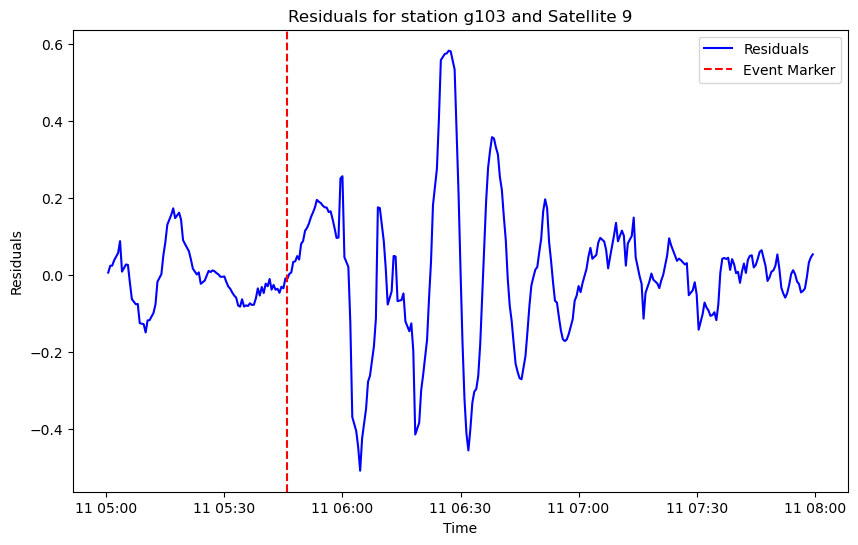

In [16]:
#This is just to check if the data added to the vsc is the same as the one calculated before 

def plot_residuals_from_filtered_csv(filename, station_id, sat_id, event_time):
    """
    Plots the residuals for a specific ground station and satellite, with the event time marked.
    
    Parameters:
    - filename: Path to the CSV file containing the filtered data with residuals.
    - station_id: The ID of the ground station (e.g., 'g103').
    - sat_id: The satellite ID (e.g., 9).
    - event_time: The specific time of the event to mark on the plot.
    """
    # Load the filtered data
    df_filtered = pd.read_csv(filename, parse_dates=['datetime'])
    df_filtered.set_index('datetime', inplace=True)
    
    # Filter for the specific station and satellite
    df_plot = df_filtered[(df_filtered['gps_site'] == station_id) & (df_filtered['sat_id'] == sat_id)]
    
    # Convert event_time to datetime for comparison
    event_time = pd.to_datetime(event_time)

    # Plot the residuals
    plt.figure(figsize=(10, 6))
    plt.plot(df_plot.index, df_plot['residuals'], label="Residuals", color="blue")
    
    plt.axvline(event_time, color='red', linestyle='--', label="Event Marker")
    plt.title(f"Residuals for station {station_id} and Satellite {sat_id}")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.legend()
    plt.show()

# Usage example
filename = 'df_filtered_copy.csv'
station_id = 'g103'
sat_id = 9
event_time = '2011-03-11 05:46:00'

plot_residuals_from_filtered_csv(filename, station_id, sat_id, event_time)


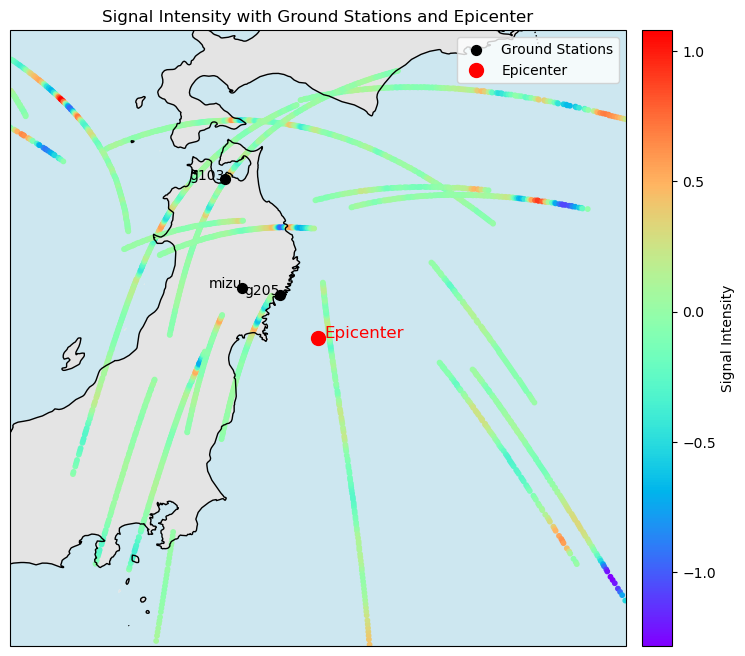

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
def plot_signal_intensity_with_satellite_list(filename, epicenter):
    """
    Plots signal intensity on a map with ground station locations, epicenter, and a list of satellites used.
    
    Parameters:
    - filename: Path to the CSV file containing the filtered data with 'gdlat', 'glon', 'gdlonr', 'gdlatr', 'gps_site', and 'band_filtered' columns.
    - epicenter: Tuple (latitude, longitude) for the epicenter.
    """
    # Define the region extent based on the epicenter, expanding 5 degrees in each direction
    region_extent = [
        epicenter[1] - 5,  # lon_min
        epicenter[1] + 5,  # lon_max
        epicenter[0] - 5,  # lat_min
        epicenter[0] + 5   # lat_max
    ]
    
    # Load the filtered data
    df_filtered = pd.read_csv(filename)

    # Filter data within the specified region extent for signal positions
    df_region = df_filtered[
        (df_filtered['glon'] >= region_extent[0]) & (df_filtered['glon'] <= region_extent[1]) &
        (df_filtered['gdlat'] >= region_extent[2]) & (df_filtered['gdlat'] <= region_extent[3])
    ]
    
    # Filter for unique ground station coordinates within the region
    df_stations = df_filtered[['gps_site', 'gdlonr', 'gdlatr']].drop_duplicates()
    df_stations_region = df_stations[
        (df_stations['gdlonr'] >= region_extent[0]) & (df_stations['gdlonr'] <= region_extent[1]) &
        (df_stations['gdlatr'] >= region_extent[2]) & (df_stations['gdlatr'] <= region_extent[3])
    ]

    # Get unique satellite IDs used in this region
    satellite_ids = df_region['sat_id'].unique()
    
    # Initialize the map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    
    # Add map features with adjusted opacity
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='none', facecolor='lightgrey', alpha=0.6)
    ax.add_feature(cfeature.OCEAN, zorder=0, edgecolor='none', facecolor='lightblue', alpha=0.6)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot signal intensity points with rainbow colormap and smaller point size
    scatter = ax.scatter(
        df_region['glon'], df_region['gdlat'],
        c=df_region['band_filtered'], cmap='rainbow', s=10,  # Reduced point size from 30 to 10
        norm=mcolors.Normalize(vmin=df_region['band_filtered'].min(), vmax=df_region['band_filtered'].max()),
        transform=ccrs.PlateCarree(), zorder=1
    )
    
    # Plot ground stations as black markers with labels
    ax.scatter(
        df_stations_region['gdlonr'], df_stations_region['gdlatr'],
        color='black', s=50, marker='o', label="Ground Stations", transform=ccrs.PlateCarree(), zorder=3
    )
    for _, row in df_stations_region.iterrows():
        ax.text(row['gdlonr'], row['gdlatr'], row['gps_site'], color="black", fontsize=10, ha='right', transform=ccrs.PlateCarree(), zorder=3)

    # Plot the epicenter in bright red with a label
    ax.plot(epicenter[1], epicenter[0], 'o', color='red', markersize=10, label="Epicenter", transform=ccrs.PlateCarree(), zorder=4)
    ax.text(epicenter[1] + 0.1, epicenter[0], 'Epicenter', color='red', fontsize=12, transform=ccrs.PlateCarree(), zorder=4)

    # Add color bar for signal intensity
    cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", pad=0.02, label="Signal Intensity (band_filtered)")
    cbar.set_label('Signal Intensity')

 

    # Map title and labels
    plt.title("Signal Intensity with Ground Stations and Epicenter")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.show()

# Usage example
#filename = 'data/data_csvs/Japan_Tsunami_11Mar2011_05_07.csv'
filename = 'df_filtered_copy.csv'
epicenter = (38 + 19 / 60 + 19 / 3600, 142 + 22 / 60 + 8 / 3600)  # Convert DMS to decimal degrees

plot_signal_intensity_with_satellite_list(filename, epicenter)
